# 中華料理店過程 Pitman-Yor過程 棒折り過程
* ノンパラメトリックベイズ の基礎
* 確率分布として各過程を理解する

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

## Hoppe's urn model
* 1個の黒玉と他の色の玉の入った壺
* 黒玉の重さを$\alpha$、色玉の重さは全て1とする。
* 壺に入っている色玉の重さの割合により抽出を繰り返す。
* 黒玉を取り出したときには壺に入っていない色の玉を無作為に選び、加える。

- Polya's url modelの変形版。
- Polyaでは新しい色玉が増えることはない。

* ホップの壺モデルでは玉を取り出す順番は関係なく、色玉の種類、各色玉の個数の２つに依存して確率が決まる。
* Ewens sampling formulaが成立する。
    $$
    P_E(n_1, \cdots, n_c) = \frac{\alpha^c \prod_{i=1}^c (n_i - 1)!}{AF(\alpha, n)}
    $$
    ただし、$AF$は上昇階乗
* 以下で上昇階乗のシミュレーションを行う。

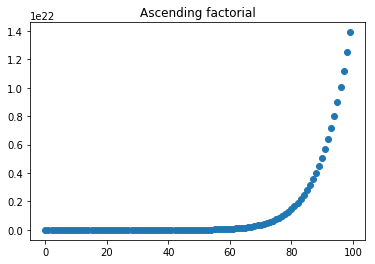

In [2]:
def AF(a, n=10):
    af = a
    for i in range(n):
        af *= a + i
    return af

afs = []
for a in range(100):
    afs.append(AF(a))
plt.plot(np.arange(100), afs, "o")
plt.title("Ascending factorial")
plt.show()

In [3]:
alpha = [1, 2, 5, 10, 20]
adds = []
clusters = []
for al in alpha:
    N = 1000
    tables = [1]
    num_person = [1]
    add_num = [1]
    cluster_len = [1]
    for n in range(2, N+1):
            prob = [num_person[i] / (n - 1 + al) for i in range(len(tables))] + [al / (n - 1 + al)]
            samp = np.random.multinomial(1, prob)
            cluster = int(np.where(samp==True)[0])
            if cluster+1 > len(num_person):
                num_person.append(1)
                tables.append(1)
            else:
                num_person[cluster] += 1
            add_num.append(n)
            cluster_len.append(len(tables))
    adds.append(add_num)
    clusters.append(cluster_len)

In [4]:
class CRP:
    """
    Chinese restaurant process 中華料理店過程
    
    Attributes
    ----------
    alpha: double
        concentration parameter
    cluster: list
        sampled paramter from base measure
    cluster_num: list
        the frequency of samples of each cluster
    ----------
    """
    def __init__(self, base_measure, base_param, alpha=2.):
        """
        Parameters
        ----------
        base_measure: function
            Base measure for CRP. 
        base_param: list
            Parameters for base measure.
        alpha: double
            Concentration parameter.
        """
        # 一人目は着席済みとする
        self.alpha = alpha
        self.base_measure = base_measure
        self.base_param = base_param
        self.cluster = np.array([base_measure(*base_param)])
        self.cluster_num = np.array([1])
    
    def simulate(self, num_sample=1000):
        """
        Simulate CRP cluster number changes as the number of samples increase.
        
        Parameters
        ----------
        num_sample: int
            the total number of samples
        
        Returns
        ----------
        table_length: list
            the simulated transition of the number of clusters
        ----------
        """
        num_person = [1]
        tables = [1]
        transition = [1]
        for n in range(2, num_sample+1):
            prob = np.append([num_person[i] / (n - 1 + self.alpha) for i in range(len(tables))],  [self.alpha / (n - 1 + self.alpha)])
            samp = np.random.multinomial(1, prob)
            cluster = int(np.where(samp==True)[0])
            if cluster+1 > len(tables): # new cluster
                num_person.append(1)
                tables.append(1)
            else: # existing cluster
                num_person[cluster] += 1
            transition.append(len(tables))
        return transition
    
    def sample(self, num_sample=1000):
        """
            base measureに従うサンプルを生成
            
            Parameters
            ----------
            num_sample: int
                the number of samples
            
            Returns
            ----------
            self.cluster: np.array
                cluster of generted parameters
            self.cluster_num: np.array
                the number of semples belonging to each clusters
            
        """
        for n in range(2, num_sample+1):
            prob = np.append([self.cluster_num[i] / (n - 1 + self.alpha) for i in range(len(self.cluster))], [self.alpha / (n - 1 + self.alpha)])
            samp = np.random.multinomial(1, prob)
            cluster = int(np.where(samp==True)[0])
            if cluster+1 > len(self.cluster_num):
                self.cluster_num = np.append(self.cluster_num, 1)
                self.cluster = np.append(self.cluster, self.base_measure(*self.base_param))
            else:
                self.cluster_num[cluster] += 1
        self.cluster_num = self.cluster_num / np.sum(self.cluster_num)
        return self.cluster, self.cluster_num  

## CRPによるサンプルと基底測度との関係
* 集中度パラメータを様々に変化させた時の基底測度との関係をみる
* サンプル数に応じてクラスタ数が変化するため、titleに生成したクラスタ数を示してある

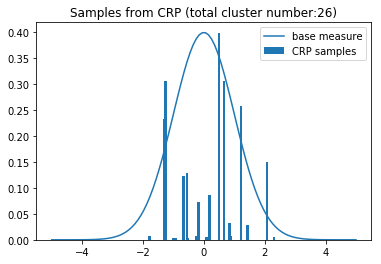

In [5]:
crp = CRP(**{"base_measure": np.random.normal, "base_param": [0, 1], "alpha": 4.})
crp.sample(**{"num_sample": 1000})
# crp2.sample(**{"base_measure": np.random.gamma, "base_param": [.8], "alpha": 3.})
xmin, xmax = -5, 5
x = np.linspace(xmin, xmax, 100)
y = scipy.stats.norm(0, 1).pdf(x)
# y = scipy.stats.gamma(.8).pdf(x)
plt.plot(x, y, label="base measure")
# plt.bar(crp.cluster, crp.cluster_num, 0.1, label="CRP samples")
plt.bar(crp.cluster, crp.cluster_num / crp.cluster_num.max() * y.max(), 0.08, label="CRP samples")
plt.title("Samples from CRP (total cluster number:{})".format(len(crp.cluster_num)))
plt.legend()
plt.show()

## CRPによるクラスタ数とサンプル数の関係
* $\alpha$によりクラスタ数の変化がどの様に変化するかをシミュレーションする

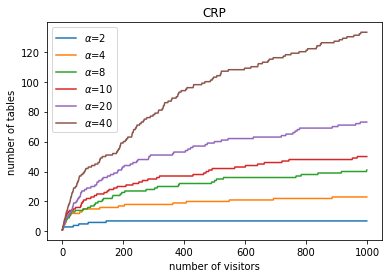

In [6]:
alpha = [2, 4, 8, 10, 20, 40]
for i in range(len(alpha)):
    crp = CRP(**{"base_measure": np.random.normal, "base_param": [0, 1], "alpha": alpha[i]})
    transition = crp.simulate()
    plt.plot(np.arange(len(transition)), transition, label=r'$\alpha$='+str(alpha[i]))
plt.legend()
plt.title("CRP")
plt.xlabel("number of visitors")
plt.ylabel("number of tables")
plt.show()

## Dirichlet processの問題点
* [参考](http://chasen.org/~daiti-m/paper/svm2006-hpylm.pdf)
* 要は、dirichlet smoothingを用いた時と同じ様に、ディリクレ過程における新規クラスタの追加にはクラスタの頻度が大きく影響する。

In [7]:
class PitmanYor:
    """
    Pitman-Yor process
        the extension of dirichlet process
    
    Attributes
    ----------
    theta: double
        Strength parameter
    d: double 0 < d < 1
        Discount parameter
    cluster: list
        sampled paramter from base measure
    cluster_num: list
        the frequency of samples of each cluster
    ----------
    """
    def __init__(self, base_measure, base_param, theta=2., d=2.):
        """
        Parameters
        ----------
        base_measure: function
            Base measure for CRP. 
        base_param: list
            Parameters for base measure.
        theta: double
            Strength parameter
        d: double
            Discount parameter
        """
        # 一人目は着席済みとする
        self.theta = theta
        self.d = d
        self.base_measure = base_measure
        self.base_param = base_param
        self.cluster = np.array([base_measure(*base_param)])
        self.cluster_num = np.array([1])
    
    def simulate(self, num_sample=1000):
        """
        Simulate CRP cluster number changes as the number of samples increase.
        
        Parameters
        ----------
        num_sample: int
            the total number of samples
        
        Returns
        ----------
        table_length: list
            the simulated transition of the number of clusters
        ----------
        """
        num_person = [1]
        tables = [1]
        transition = [1]
        for n in range(2, num_sample+1):
            prob = np.append([(num_person[i] - self.d) / (n - 1 + self.theta) for i in range(len(tables))],  [(self.theta + self.d * len(tables)) / (n - 1 + self.theta)])
            samp = np.random.multinomial(1, prob)
            cluster = int(np.where(samp==True)[0])
            if cluster+1 > len(tables): # new cluster
                num_person.append(1)
                tables.append(1)
            else: # existing cluster
                num_person[cluster] += 1
            transition.append(len(tables))
        return transition
    
    def sample(self, num_sample=1000):
        """
            Generate samples from Pitman-Yor process
            
            Parameters
            ----------
            num_sample: int
                the number of samples
            
            Returns
            ----------
            self.cluster: np.array
                cluster of generted parameters
            self.cluster_num: np.array
                the number of semples belonging to each clusters
            
        """
        for n in range(2, num_sample+1):
            prob = np.append([(self.cluster_num[i] - self.d) / (n - 1 + self.theta) for i in range(len(self.cluster))], [(self.theta + self.d * len(self.cluster)) / (n - 1 + self.theta)])
            samp = np.random.multinomial(1, prob)
            cluster = int(np.where(samp==True)[0])
            if cluster+1 > len(self.cluster_num):
                self.cluster_num = np.append(self.cluster_num, 1)
                self.cluster = np.append(self.cluster, self.base_measure(*self.base_param))
            else:
                self.cluster_num[cluster] += 1
        self.cluster_num = self.cluster_num / np.sum(self.cluster_num)
        return self.cluster, self.cluster_num  

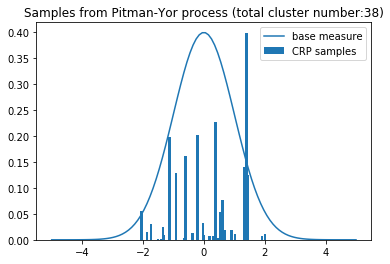

In [8]:
py = PitmanYor(**{"base_measure": np.random.normal, "base_param": [0, 1], "theta": 4., "d": 0.2})
py.sample(**{"num_sample": 1000})
# crp2.sample(**{"base_measure": np.random.gamma, "base_param": [.8], "alpha": 3.})
xmin, xmax = -5, 5
x = np.linspace(xmin, xmax, 100)
y = scipy.stats.norm(0, 1).pdf(x)
# y = scipy.stats.gamma(.8).pdf(x)
plt.plot(x, y, label="base measure")
# plt.bar(crp.cluster, crp.cluster_num, 0.1, label="CRP samples")
plt.bar(py.cluster, py.cluster_num / py.cluster_num.max() * y.max(), 0.08, label="CRP samples")
plt.title("Samples from Pitman-Yor process (total cluster number:{})".format(len(py.cluster_num)))
plt.legend()
plt.show()

In [9]:
theta = 2
# alpha = 8
d = [0, 0.2, 0.3, 0.4]
for i in range(len(beta)):
    py = PitmanYor(**{"base_measure": np.random.normal, "base_param": [0, 1], "theta": theta, "d": d[i]})
    transition = py.simulate(1000)
    plt.plot(np.arange(len(transition)), transition, label=r'$d$='+str(d[i]))
plt.legend()
plt.title("Pitman-Yor" + r'($\theta$=' + str(theta)+")")
plt.xlabel("number of visitors")
plt.ylabel("number of tables")
plt.show()

NameError: name 'beta' is not defined

## SBP
$$
\begin{aligned}
\theta_i &\sim G_0(\theta) \\
\pi_i &= v_i \sim Be(1, \alpha) \\
\mathbf{\pi} &\sim SBP(\alpha) \\
G(\mathbf{\theta}) &= \sum_{i=1}^\infty \pi_i\delta_{\mathbf{\theta}_i}
\end{aligned}
$$

In [ ]:
class SBP:
    def __init__(self, base_measure, base_param, alpha=2., num_break=100):
        self.alpha = alpha
        self.base_measure = base_measure
        self.base_param = base_param
        self.num_break = num_break
        self.v = []
        self.pi = []
        self.cluster = []
        self.cluster_num = []
        self.breaking()
    
    def breaking(self):
        for i in range(1, self.num_break+1):
            v_i = np.random.beta(a=1, b=self.alpha) # breaking
            pi_i = np.prod(self.v)
            self.pi.append(pi_i)
            self.v.append(1 - v_i)
            self.cluster.append(self.base_measure(*self.base_param))
        self.pi = self.pi / np.sum(self.pi)
        self.cluster_num = [0 for _ in range(len(self.pi))]
        
    def simulate(self, alpha=2., num_sample=1000):
        num_person = [0 for _ in range(len(self.pi))]
        tables = [0 for _ in range(len(self.pi))]
        transition = []
        for i in range(num_sample):
            samp = int(np.where(np.random.multinomial(1, self.pi)==True)[0])
            tables[samp] = 1
            num_person[samp] += 1
            transition.append(np.count_nonzero(tables))
        return transition
        
    def sample(self, num_sample=1000):
        for i in range(num_sample):    
            samp = int(np.where(np.random.multinomial(1, self.pi / np.sum(self.pi))==True)[0])
            self.cluster_num[samp] += 1
        return self.pi

In [ ]:
sbp = SBP(**{"base_measure": np.random.normal, "base_param": [0, 1], "alpha": 4., "num_break": 100,})
sbp.sample(num_sample=1000)

xmin, xmax = -5, 5
x = np.linspace(xmin, xmax, 100)
y = scipy.stats.norm(0, 1).pdf(x)
# y = scipy.stats.gamma(.8).pdf(x)
plt.plot(x, y, label="base measure")
# plt.bar(crp.cluster, crp.cluster_num, 0.1, label="CRP samples")
plt.bar(sbp.cluster, sbp.cluster_num / np.sum(sbp.cluster_num), 0.08)
# plt.bar(sbp.cluster, sbp.cluster_num, 0.08)
plt.title("Samples from SBP (total cluster number:{})".format(np.count_nonzero(sbp.cluster_num)))
plt.legend()
plt.show()

In [ ]:
sbp = SBP(**{"base_measure": np.random.normal , "base_param": [0, 1] , "alpha": 2., "num_break": 100})
tb = sbp.simulate(1000)
plt.plot(np.arange(len(tb)), tb)
plt.show()
# pi = sbp.sample(alpha=1)
# plt.bar(np.arange(len(pi)), pi, 0.1)
# plt.show()

## Beta-Bernoulli process
* 無限バイナリ行列の生成
* $\delta_{\mathbf{\theta}_i}$は、$B(\mathbf{\theta})$を基底測度とするディリクレ過程により生成された$\mathbf{\theta}_i$を無限個のアトムとして重みづけたものである。
$$
\begin{aligned}
B(\mathbf{\theta}) = \sum_{i=1}^{\infty} w_i \delta_{\mathbf{\theta}_i}
\end{aligned}
$$

In [ ]:
sbp = SBP(**{"base_measure": np.random.normal, "base_param": [0, 1], "alpha": 4, "num_break": 20, })
sbp.sample(**{"num_sample": 10000})

probs = sbp.cluster_num / np.max(sbp.cluster_num)
b_i = np.random.binomial(1, probs)
# plt.bar(sbp.cluster, sbp.cluster_num, 0.08)
len(b_i)
b = []
for i in range(20):
    b_i = np.random.binomial(1, probs)
    b.append(b_i)
b = np.array(b)
print(b.shape)
tate = 1
yoko = 1
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
for t in range(b.shape[0]):
    for y in range(b.shape[1]):
#         print(b[t][y])
        if b[t][y]:
            r = patches.Rectangle(xy=(y*yoko, t*tate), width=yoko, height=tate, fill=True)
        else:
            r = patches.Rectangle(xy=(y*yoko, t*tate), width=yoko, height=tate, fill=False)
        ax.add_patch(r)
plt.axis('scaled')
ax.set_aspect('equal')
plt.title("Binary matrix from beta-bernoulli process")
plt.xlabel("breaking cluster")
plt.ylabel("number of samples")
plt.show()